# **TASK#1: Anti-Cheat Pre-Filter**

Karena Thailand receives over 10,000 cheat reports daily across all games, but the manual review team can only handle 500 cases per day, creating a massive backlog of 45,000+ pending reports. Many reports are false positives from frustrated players who lost matches fairly, while real cheaters continue to damage game experience and drive legitimate players away. The current automated system has a 70% false positive rate, meaning innocent players get flagged and sometimes banned, leading to customer service nightmares and permanent player loss. Meanwhile, sophisticated cheaters who use subtle aimbots or wallhacks slip through undetected. Player retention has dropped 15% in competitive game modes due to cheating complaints, directly impacting revenue by approximately ฿15 million daily. The company needs an intelligent pre-filtering system that can accurately identify high-probability cheaters for priority manual review, reducing workload while catching real threats

# **STEP 1: Setup & Data Loading**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
TRAIN_FILE = '/content/drive/MyDrive/2568/[CPE342]Project/train.csv'
TEST_FILE = '/content/drive/MyDrive/2568/[CPE342]Project/test.csv'
SUBMISSION_FILE = 'submission-task1_improved.csv'

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

TASK1_TARGET = 'is_cheater'

# **STEP 2: Data Exploration & Feature Engineering**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99872 entries, 0 to 99871
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       99872 non-null  object 
 1   player_id                99872 non-null  object 
 2   kill_death_ratio         97521 non-null  float64
 3   headshot_percentage      84716 non-null  float64
 4   win_rate                 90015 non-null  float64
 5   accuracy_score           96848 non-null  float64
 6   kill_consistency         97281 non-null  float64
 7   reaction_time_ms         73815 non-null  float64
 8   account_age_days         81323 non-null  float64
 9   level                    75795 non-null  float64
 10  level_progression_speed  80614 non-null  float64
 11  friend_network_size      91713 non-null  float64
 12  reports_received         75722 non-null  float64
 13  device_changes_count     90774 non-null  float64
 14  input_consistency_scor

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25889 entries, 0 to 25888
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       25889 non-null  object 
 1   player_id                25889 non-null  object 
 2   kill_death_ratio         22986 non-null  float64
 3   headshot_percentage      23410 non-null  float64
 4   win_rate                 22689 non-null  float64
 5   accuracy_score           24820 non-null  float64
 6   kill_consistency         22718 non-null  float64
 7   reaction_time_ms         25063 non-null  float64
 8   account_age_days         23526 non-null  float64
 9   level                    23289 non-null  float64
 10  level_progression_speed  24215 non-null  float64
 11  friend_network_size      22635 non-null  float64
 12  reports_received         23165 non-null  float64
 13  device_changes_count     24697 non-null  float64
 14  input_consistency_scor

In [ ]:
task1_features = df_train.select_dtypes(include=np.number).columns.tolist()
for col_remove in ['is_cheater', 'player_id']:
    if col_remove in task1_features:
        task1_features.remove(col_remove)

# add features
df_train["sum_features"] = df_train[task1_features].sum(axis=1)
df_train["mean_features"] = df_train[task1_features].mean(axis=1)

df_test["sum_features"] = df_test[task1_features].sum(axis=1)
df_test["mean_features"] = df_test[task1_features].mean(axis=1)

task1_features += ["sum_features", "mean_features"]

# **STEP 3: Data Preprocessing**

In [ ]:
# Missing Values
for col in task1_features:
    med = df_train[col].median()
    df_train[col] = df_train[col].fillna(med)
    df_test[col] = df_test[col].fillna(med)

df_train = df_train.dropna(subset=[TASK1_TARGET])
df_train[TASK1_TARGET] = df_train[TASK1_TARGET].astype(int)

# **STEP 4: EDA - Target & Correlation Analysis**

/tmp/ipython-input-2593174527.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=TASK1_TARGET, data=df_train, palette='viridis')


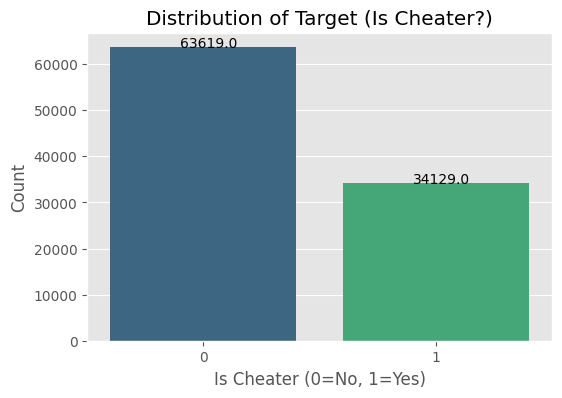

Ratio of Cheaters: 34.92%


In [ ]:
plt.style.use('ggplot')

# Show Is Cheater
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=TASK1_TARGET, data=df_train, palette='viridis')
plt.title('Distribution of Target (Is Cheater?)')
plt.xlabel('Is Cheater (0=No, 1=Yes)')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 50))
plt.show()

print(f"Ratio of Cheaters: {df_train[TASK1_TARGET].mean():.2%}")

/tmp/ipython-input-3926564141.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='coolwarm')


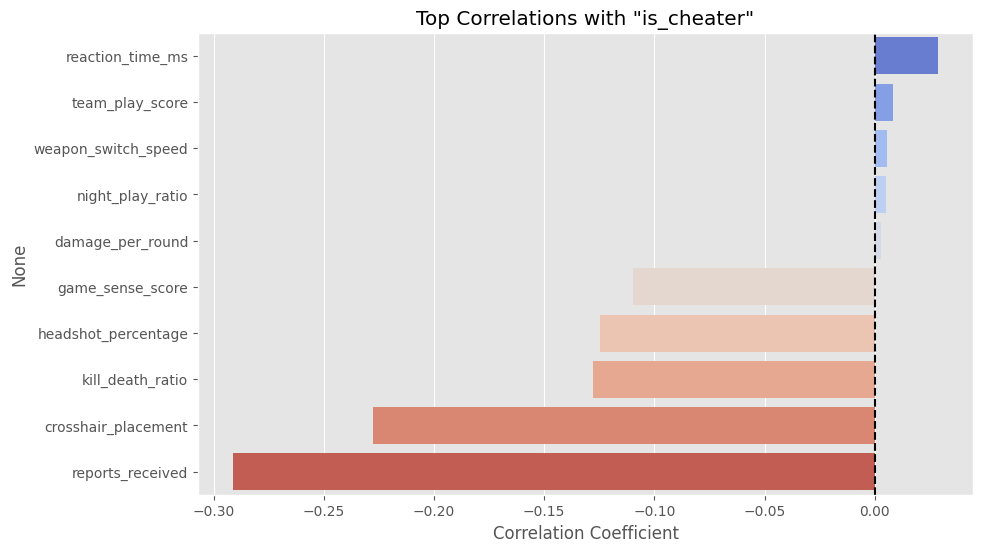

In [ ]:
# Correlation & Target
corr_matrix = df_train[task1_features + [TASK1_TARGET]].corr()
target_corr = corr_matrix[TASK1_TARGET].drop(TASK1_TARGET).sort_values(ascending=False)

top_corr_features = pd.concat([target_corr.head(5), target_corr.tail(5)])

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='coolwarm')
plt.title('Top Correlations with "is_cheater"')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

# **STEP 5: Model Preparation**

In [ ]:
# Train/Validation Split
X = df_train[task1_features]
y = df_train[TASK1_TARGET]

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **STEP 6: Model Training & Hyperparameter Tuning**

In [ ]:
# Improve Model (Better Hyperparameters)
model_task1 = RandomForestClassifier(
    n_estimators=600,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

model_task1.fit(X_tr, y_tr)

val_prob = model_task1.predict_proba(X_val)[:, 1]
val_pred = model_task1.predict(X_val)

acc = accuracy_score(y_val, val_pred)
auc = roc_auc_score(y_val, val_prob)

print("Validation Accuracy:", acc)
print("Validation AUC:", auc)

Validation Accuracy: 0.7585677749360614
Validation AUC: 0.8787836013216843


# **STEP 7: Post-Processing (Threshold Tuning)**

In [ ]:
# Search Best Threshold
best_t = 0.5
best_auc = 0

for t in np.linspace(0.1, 0.9, 81):
    pred_t = (val_prob >= t).astype(int)
    auc_t = roc_auc_score(y_val, pred_t)
    if auc_t > best_auc:
        best_auc = auc_t
        best_t = t

print("Best Threshold =", best_t)

Best Threshold = 0.52


# **STEP 8: Final Training & Prediction**

In [ ]:
# Train Full Model
model_task1.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=600, n_jobs=-1, random_state=42)

In [ ]:
# Predict Test (use best threshold)
test_prob = model_task1.predict_proba(df_test[task1_features])[:, 1]
predictions_task1 = (test_prob >= best_t).astype(int)

# **STEP 9: Submission Export**

In [ ]:
# Create Submission
submission_df = pd.DataFrame({
    "id": df_test["id"],
    "task1": predictions_task1.astype(int),
    "task2": 0,
    "task3": 0,
    "task4": 0,
    "task5": 0
})

submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n Create file '{SUBMISSION_FILE}' Complete")


 Create file 'submission-task1_improved.csv' Complete
